In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       pass

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
pil_im = Image.open('/kaggle/input/logocanal/LOGO PNG.png')
pil_im

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/logocanal/LOGO PNG.png'

# Lendo arquivos de Raio X com Pneumonia

In [3]:
from os import listdir
from os.path import isfile, join

mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

pneumonia_files = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

pneumo_class=[1 for f in listdir(mypath) if isfile(join(mypath, f))]

## Lendo arquivos de Raio X com Pneumonia para Validação

In [4]:
from os import listdir
from os.path import isfile, join

mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'

pneumonia_files_val = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

pneumo_class_val=[1 for f in listdir(mypath) if isfile(join(mypath, f))]

# Lendo arquivos de Raio X sem Pneumonia

In [5]:
mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'

normal_files = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

normal_class=[0 for f in listdir(mypath) if isfile(join(mypath, f))]

In [6]:
mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/'

normal_files_val = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

normal_class_val=[0 for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
pneumonia_files=pneumonia_files[:len(normal_files)]
pneumo_class=pneumo_class[:len(normal_files)]

In [8]:
import pandas as pd
df_pneumo=pd.DataFrame(pneumonia_files,columns=['filename'])
df_pneumo['class']=pneumo_class

df_normal=pd.DataFrame(normal_files,columns=['filename'])
df_normal['class']=normal_class

df=pd.concat([df_pneumo,df_normal],axis=0)

In [9]:
import pandas as pd
df_pneumo_val=pd.DataFrame(pneumonia_files_val,columns=['filename'])
df_pneumo_val['class']=pneumo_class_val

df_normal_val=pd.DataFrame(normal_files_val,columns=['filename'])
df_normal_val['class']=normal_class_val

df_val=pd.concat([df_pneumo_val,df_normal_val],axis=0)

In [10]:
df=df.sample(frac=1)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
it = datagen.flow_from_dataframe(dataframe=df,batch_size=10,image_size=(256, 256),class_mode='raw')


Found 2682 validated image filenames.


# Retornando imagens para apresentação

In [12]:
images,labels=it.next()

# Mostrando imagens de exemplo

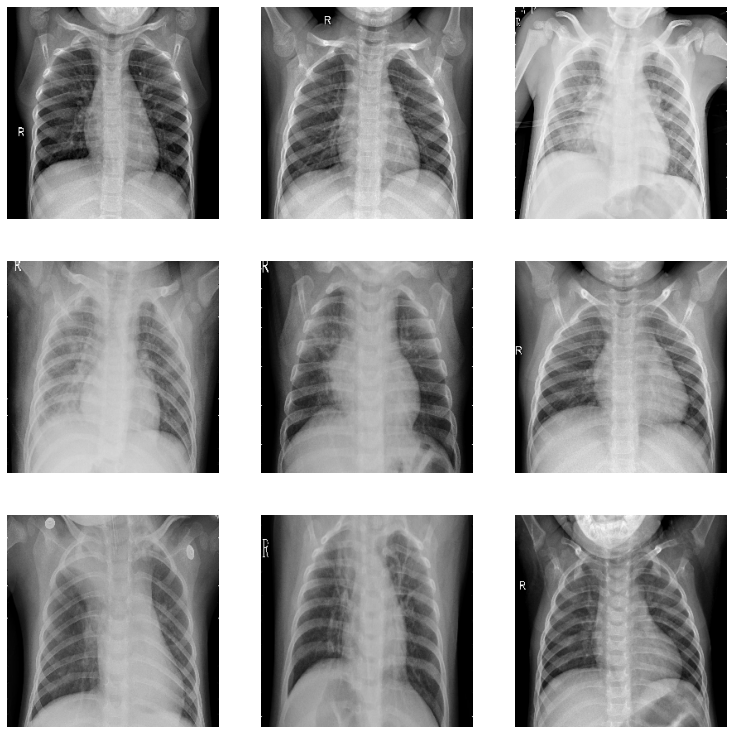

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100,100))
plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)

# generate samples and plot
for i in range(9):
    plt.subplot(330 + 1 + i)
    images,labels = it.next()
    image = images[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')
# show the figure
plt.show()

In [14]:
datagen = ImageDataGenerator(width_shift_range=[-10,10],horizontal_flip=True,rescale=1.0/255.0)
it = datagen.flow_from_dataframe(dataframe=df,batch_size=10,image_size=(256, 256),class_mode='raw')

Found 2682 validated image filenames.


In [15]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
it_val = datagen.flow_from_dataframe(dataframe=df_val,image_size=(256, 256),class_mode='raw',batch_size=10)

Found 16 validated image filenames.


# Criando Rede Neural Usando Transfer Learning

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [17]:
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(256, 256, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/kaggle/working/model.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001)
early = EarlyStopping(monitor='val_accuracy',  patience=2, 
                      verbose=2, mode='auto',
                      restore_best_weights=True)

In [19]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

# Definindo otimizador e compilando modelo

In [20]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


NameError: name 'model' is not defined

# Treinando o modelo

In [21]:


history = model.fit_generator(steps_per_epoch=269,generator=it,validation_data=it_val,
                              epochs=40,callbacks=[checkpoint,early,reduce_lr])

NameError: name 'model' is not defined

In [22]:
mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/'

normal_files = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

normal_class=[0 for f in listdir(mypath) if isfile(join(mypath, f))]

In [23]:
mypath='/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

pneumonia_files = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

pneumo_class=[1 for f in listdir(mypath) if isfile(join(mypath, f))]

In [24]:
df_pneumo=pd.DataFrame(pneumonia_files,columns=['filename'])
df_pneumo['class']=pneumo_class

df_normal=pd.DataFrame(normal_files,columns=['filename'])
df_normal['class']=normal_class

df=pd.concat([df_pneumo,df_normal],axis=0)